# Jupyter Notebook for Systematic Analysis of Deep Hedging Algorithm for a Plain Vanilla Call Option

# Table of Contents
* [Import and Setup](#chapter1)
* [Exp1](#chapter2)
    * [Abschnitt 2.1](#section_2_1)
        * [Unterabschnitt 2.1.1](#sub_section_2_1_1)
        * [Unterabschnitt 2.1.2](#sub_section_2_1_2)


# Import and Setup <a id="chapter1"></a>

In [1]:
import datetime as dt
import sys
sys.path.insert(0,'../..')
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import numpy as np
from scipy.special import comb
import pandas as pd
import seaborn
import pprint
import deepdiff
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import plotly.express as px
import plotly
plotly.offline.init_notebook_mode()
import plotly.graph_objects as go

from rivapy.tools.datetime_grid import DateTimeGrid
from rivapy.models.gbm import GBM
from rivapy.instruments.specifications import EuropeanVanillaSpecification
from rivapy.pricing.vanillaoption_pricing import VanillaOptionDeepHedgingPricer, DeepHedgeModel 


import analysis

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

c:\Users\Anwender\Documents\GitHub\RiVaPy_development\RiVaPy\sandbox\vanillaoption\../..\rivapy\__init__.py:11: UserWarning:

The pyvacon module is not available. You may not use all functionality without this module. Consider installing pyvacon.



In [3]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    for k in ref_keys:
        sim_results[k] = repo.simulate_model(k, n_sims=100_000)
    paths = {k:{'ADS':sim_results[k]} for k in ref_keys}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k) for k in ref_keys}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec']) for k in ref_keys}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -2, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))




# Exp1<a id="chapter2"></a>

In [3]:
repo = analysis.Repo('./experiments_find_best_setup_of_NN/')
key_list = list(repo.results.keys())

In [10]:
experiments = {}
key_list = []
for k,v in repo.results.items():
    #if v['params']['tc'] == 0:
    #print(v['pricing_param']['transaction_cost']['ADS'])
    if ((v['pricing_param']['transaction_cost']['ADS'][0] == 0.0) 
    and (v['pricing_param']['test_weighted_paths'] == True)):   
        key_list.append(k)
tmp={
        'ref_keys':key_list[:],
        'labels':{ k: k[:5] for k in key_list[:]           
        }
}
experiments['depp'] = tmp

In [13]:
experiment = 'depp'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results,hedge_models,specs, paths,delta,pnl  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
3125/3125 [==============================] - 3s 958us/step


In [48]:
best = repo.results['5f85a9eb0f5734325e5e90fd7bf7e182c8c8ea52']
best

{'val_date': '2023-01-01T00:00:00',
 'spec': {'id': 'Test_call',
  'issuer': 'DBK',
  'sec_lvl': 'COLLATERALIZED',
  'curr': 'EUR',
  'udl_id': 'ADS',
  'type': 'CALL',
  'expiry': '2023-01-31T00:00:00',
  'strike': 1.0,
  'share_ratio': 1},
 'model': {'drift': 0.0, 'volatility': 0.2, 'cls': 'GBM'},
 'pricing_param': {'depth': 3,
  'nb_neurons': 16,
  'n_sims': 100000,
  'regularization': 0.0,
  'epochs': 400,
  'verbose': 1,
  'tensorboard_logdir': 'logs/20240319T062227',
  'initial_lr': 0.005,
  'decay_steps': 16000,
  'batch_size': 64,
  'decay_rate': 0.95,
  'seed': 42,
  'transaction_cost': {'ADS': [0.0]},
  'test_weighted_paths': True},
 'spec_hash': '4fb89eed54d4f7a0b04bc0c9709066b35a020b94',
 'model_hash': '2d147eac1c9d5a02dbb94b5584cec15e58567809',
 'pricing_params_hash': '24a833ac41784b1e4bb0afd3aceb93106a881117',
 'pnl_result': {'mean': -0.023252792417315274,
  'var': 1.806110982153372e-05,
  'loss': 1.7479704183642752e-05,
  '1%': -0.03618423061661904,
  '99%': -0.013115834

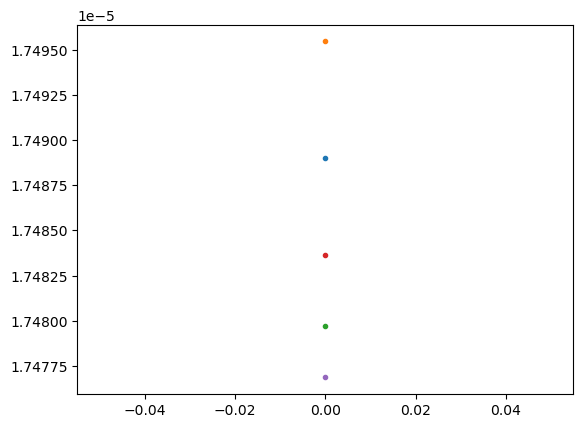

In [41]:
new_key_list = []
for i in range(len(key_list)):
    loss = repo.results[key_list[i]]['pnl_result']['loss']
    if loss < 1.75e-5:
        new_key_list.append(key_list[i][:5])
        plt.plot(repo.results[key_list[i]]['pnl_result']['loss'],'.')
#30.0/365.0

In [42]:
df = pd.DataFrame.from_dict(delta)
df =df.rename(columns=tmp['labels'])
df.insert(0, "v", sim_results[key_list[0]][-2,:], True)
model = GBM(drift = 0., volatility=0.2)
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30)
delta_BS = model.compute_BS_delta(df['v'],timegrid)
df.insert(1, "Black Scholes", delta_BS, True)

In [43]:
df = df[new_key_list]
df.insert(0, "v", sim_results[key_list[0]][-2,:], True)
model = GBM(drift = 0., volatility=0.2)
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30)
delta_BS = model.compute_BS_delta(df['v'],timegrid)
df.insert(1, "Black Scholes", delta_BS, True)

In [44]:
df

v  Black Scholes     0b31c     b5df7     5f85a     55a19  \
0      0.943049   1.879909e-08 -0.005838 -0.002818 -0.006203  0.001595   
1      0.950532   9.704455e-07 -0.003248 -0.000617 -0.001530  0.006726   
2      0.997011   3.913553e-01  0.432301  0.457308  0.426419  0.435562   
3      0.984010   6.570742e-02  0.187664  0.178856  0.168566  0.172733   
4      0.965472   4.924723e-04  0.015984  0.025791  0.023047  0.020742   
...         ...            ...       ...       ...       ...       ...   
99995  1.030205   9.974460e-01  0.966231  0.958964  0.958898  0.957398   
99996  1.045006   9.999826e-01  1.007278  0.992613  0.999756  1.003607   
99997  1.139613   1.000000e+00  0.986412  0.992117  0.991408  1.005573   
99998  0.962851   1.924818e-04  0.008770  0.016753  0.016378  0.017869   
99999  0.998145   4.328704e-01  0.460970  0.482818  0.452685  0.461240   

          9882f  
0     -0.007668  
1     -0.004001  
2      0.431278  
3      0.167720  
4      0.024786  
...         ...  
99995  0.957464  
99996  1.012748  
99997  0.994232  
99998  0.017842  
99999  0.457816  

[100000 rows x 7 columns]

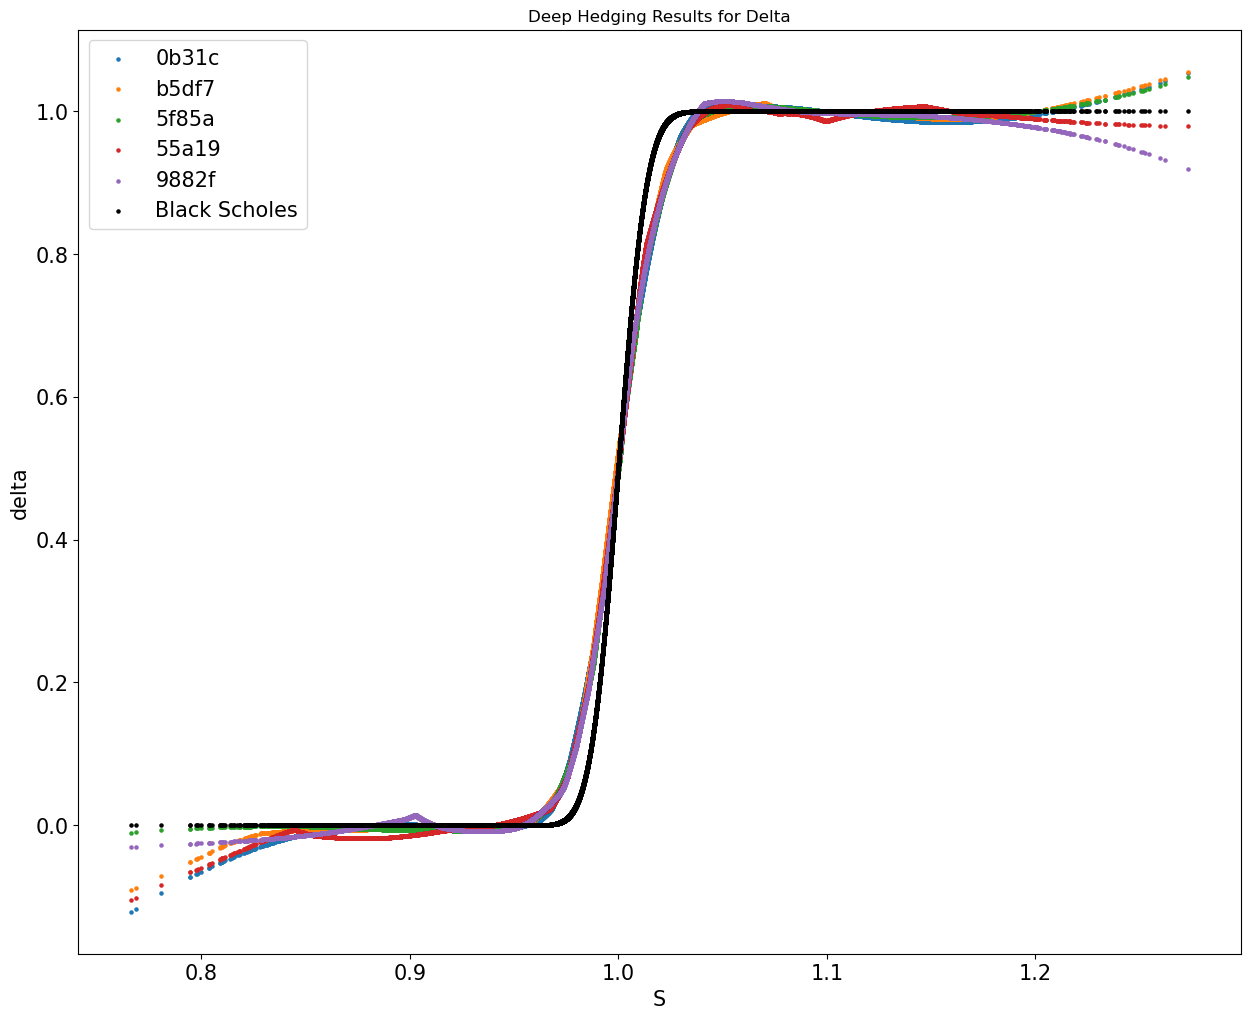

In [51]:
size = 15
plt.figure(figsize=(15,12))
for i in range(2,len(df.columns)):
    plt.scatter(x = df['v'], y = df[df.columns[i]], label = df.columns[i], s = 5)
plt.scatter(x = df['v'], y = df['Black Scholes'], label ='Black Scholes', color = 'black',s =5)
plt.legend(fontsize=size)
plt.xlabel('S',size = size)
plt.ylabel('delta',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.title('Deep Hedging Results for Delta')
#plt.xlim([0.95,1.05])
plt.show()

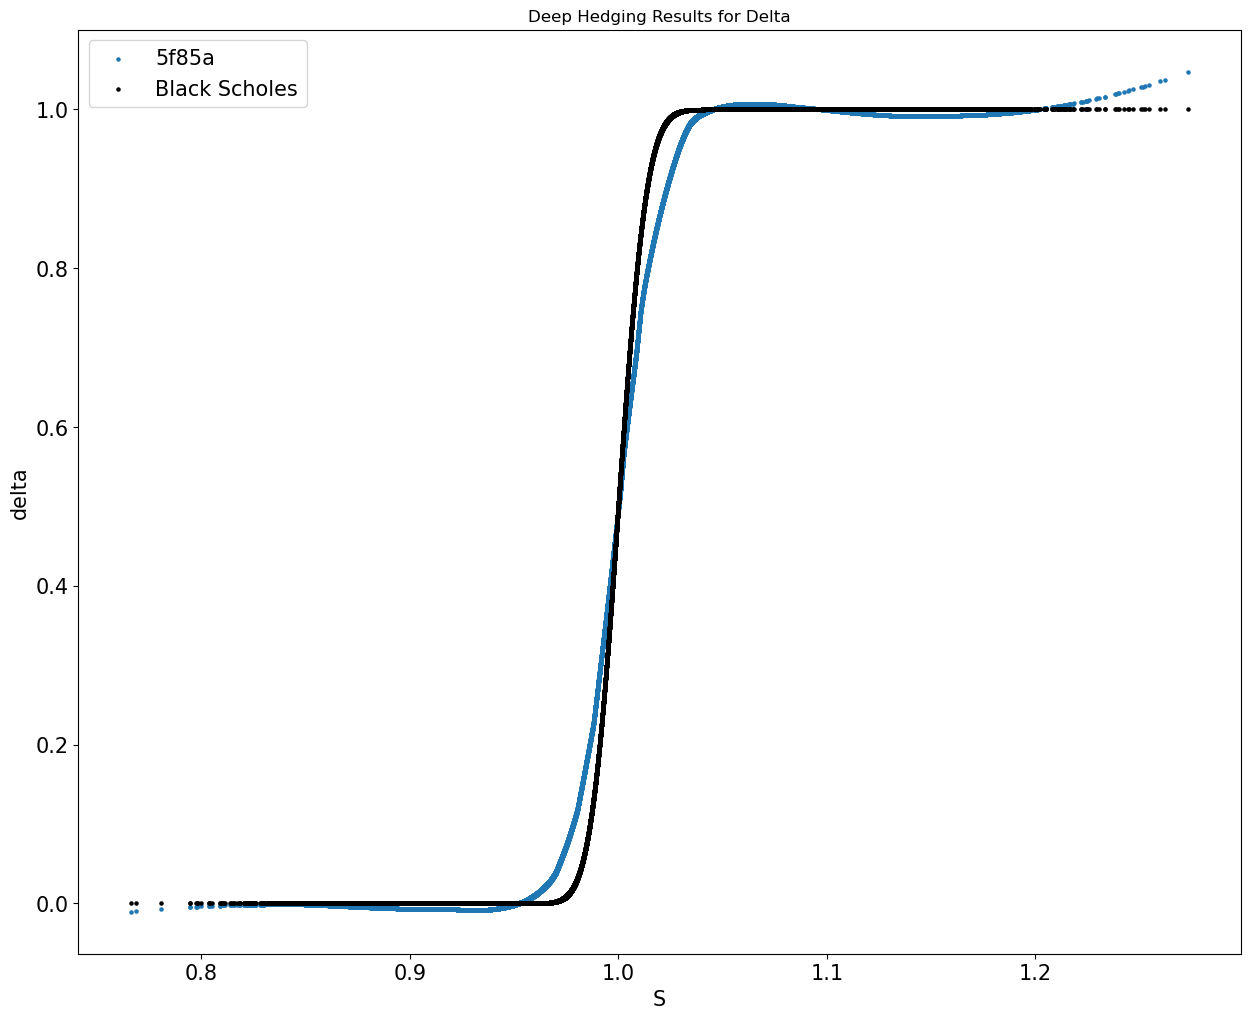

In [52]:
size = 15
plt.figure(figsize=(15,12))
plt.scatter(x = df['v'], y = df['5f85a'], label = '5f85a', s = 5)
plt.scatter(x = df['v'], y = df['Black Scholes'], label ='Black Scholes', color = 'black',s =5)
plt.legend(fontsize=size)
plt.xlabel('S',size = size)
plt.ylabel('delta',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.title('Loss ')
#plt.xlim([0.95,1.05])
plt.show()

In [53]:
df_pnl = pd.DataFrame.from_dict(pnl)
df_pnl =df_pnl.rename(columns=tmp['labels'])
df_pnl = df_pnl[new_key_list]

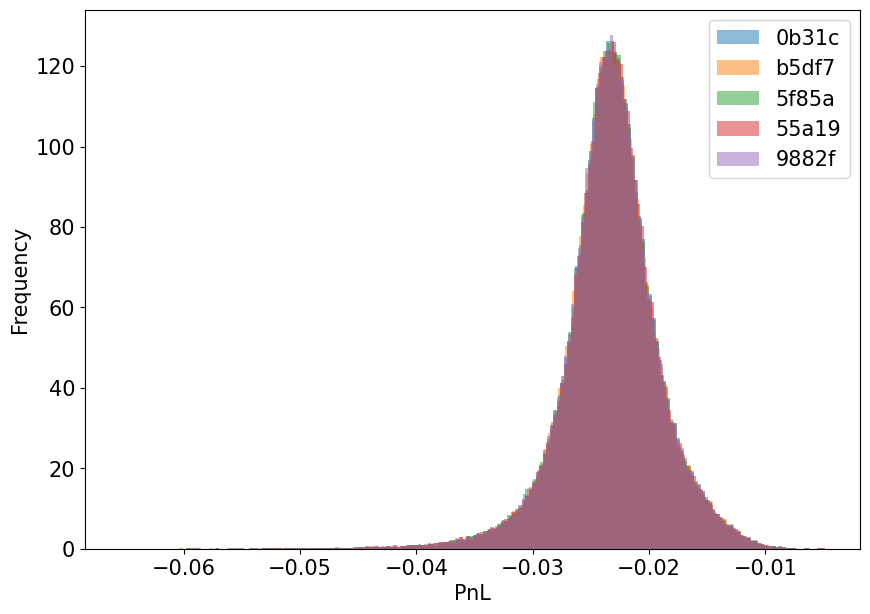

In [54]:
size = 15
plt.figure(figsize=(10,7))
for i in range(len(df_pnl.columns)):
    plt.hist(df_pnl[df_pnl.columns[i]], bins=200, label=df_pnl.columns[i], density=True, alpha=0.5)
plt.legend(fontsize=size)
plt.xlabel('PnL',size = size)
plt.ylabel('Frequency',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xlim([0.95,1.05])
plt.show()

# Exp2: Weighted Paths (in bins), 50 Epochs

In [60]:
repo = analysis.Repo('./experiments/')
key_list = list(repo.results.keys())

In [82]:
experiments = {}
key_list = []
for k,v in repo.results.items():  
    key_list.append(k)
tmp={
        'ref_keys':key_list[:],
        'labels':{ k: k[:5] for k in key_list[:]           
        }
}
experiments['depp2'] = tmp

In [83]:
experiment = 'depp2'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_results,hedge_models,specs, paths,delta,pnl  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
3125/3125 [==============================] - 3s 974us/step


In [87]:
df = pd.DataFrame.from_dict(delta)
df =df.rename(columns=tmp['labels'])
df.insert(0, "v", sim_results[key_list[1]][-2,:], True)
model = GBM(drift = 0., volatility=0.2)
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30)
delta_BS = model.compute_BS_delta(df['v'],timegrid)
df.insert(1, "Black Scholes", delta_BS, True)

In [85]:
df

v  Black Scholes     7fa8b     3e1bc
0      0.943049   1.879909e-08  0.000344  0.095023
1      0.950532   9.704455e-07  0.003622  0.115798
2      0.997011   3.913553e-01  0.418674  0.446210
3      0.984010   6.570742e-02  0.169115  0.276049
4      0.965472   4.924723e-04  0.012807  0.170654
...         ...            ...       ...       ...
99995  1.030205   9.974460e-01  0.950732  0.785545
99996  1.045006   9.999826e-01  1.001912  0.855127
99997  1.139613   1.000000e+00  0.992681  1.002762
99998  0.962851   1.924818e-04  0.007669  0.159521
99999  0.998145   4.328704e-01  0.446854  0.460178

[100000 rows x 4 columns]

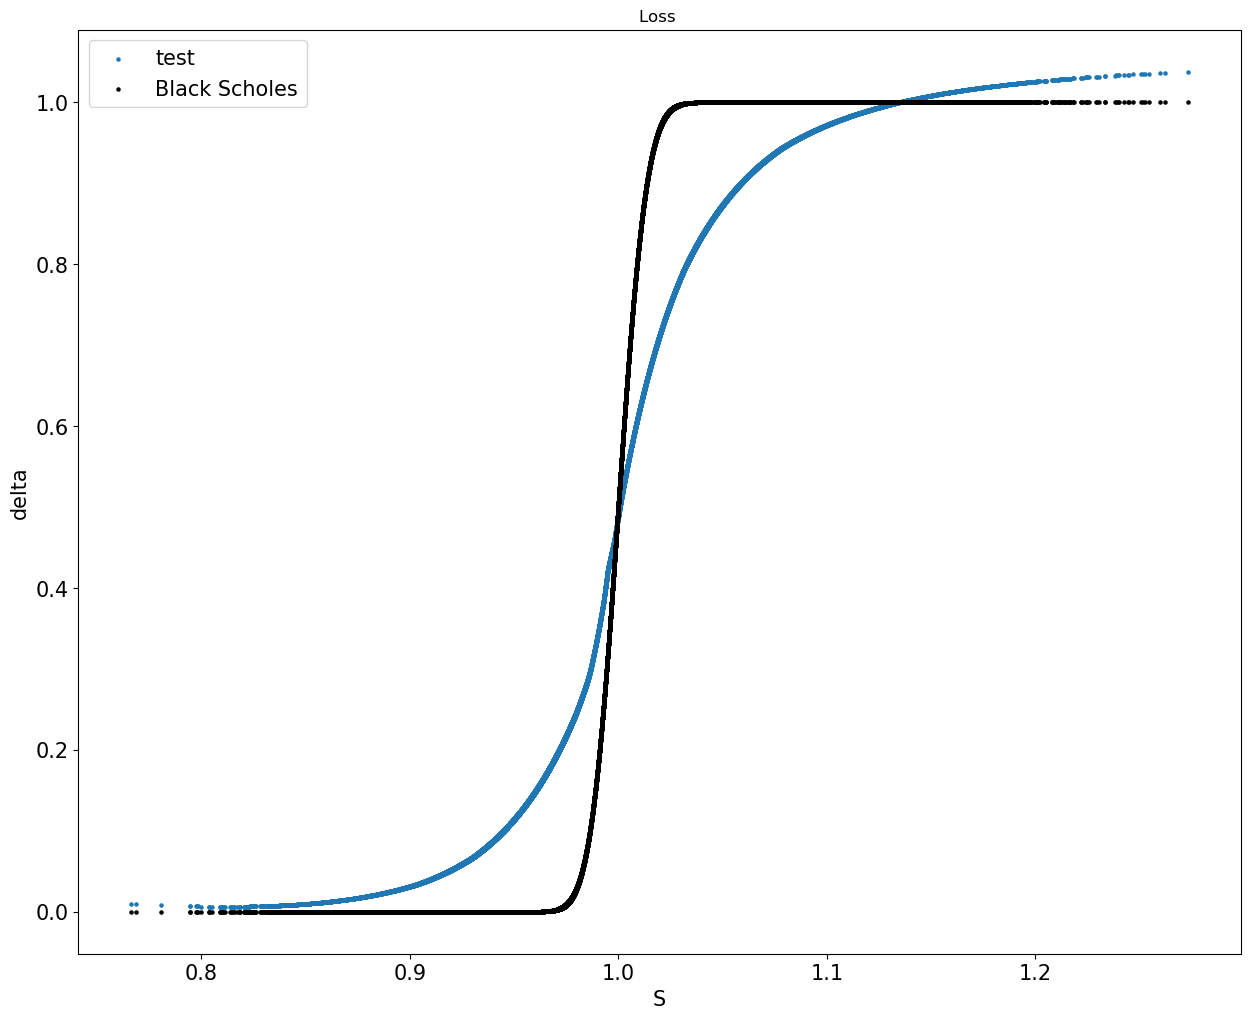

In [95]:
size = 15
plt.figure(figsize=(15,12))
plt.scatter(x = df['v'], y = df['3e1bc'], label = 'test', s = 5)
plt.scatter(x = df['v'], y = df['Black Scholes'], label ='Black Scholes', color = 'black',s =5)
plt.legend(fontsize=size)
plt.xlabel('S',size = size)
plt.ylabel('delta',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.title('Loss ')
#plt.xlim([0.95,1.05])
plt.show()

In [96]:
from rivapy.models.gbm import GBM
from rivapy.models.heston_for_DH import HestonForDeepHedging

In [98]:
np.random.seed(42)
n = 30#365
T = 30/365
timegrid = np.linspace(0.0,T,n) # simulate on daily timegrid over 30 days
n_sims = 1000
S0 = 1.
v0 = 0.04
model = GBM(drift = 0., volatility=0.2)
paths_GBM = model.simulate(timegrid, start_value=S0,M = n_sims, n=n)
model = HestonForDeepHedging(rate_of_mean_reversion = 1.,long_run_average = 0.04,
                  vol_of_vol = 2., correlation_rho = -0.7)
paths_Heston = model.simulate(timegrid, S0=S0, v0=v0, M=n_sims,n=n)

Text(0, 0.5, 'S2(t)')

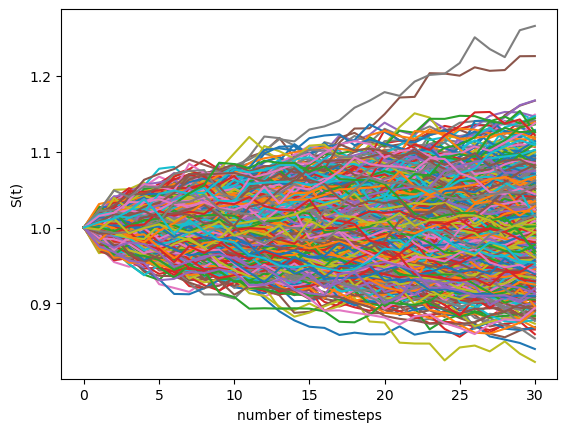

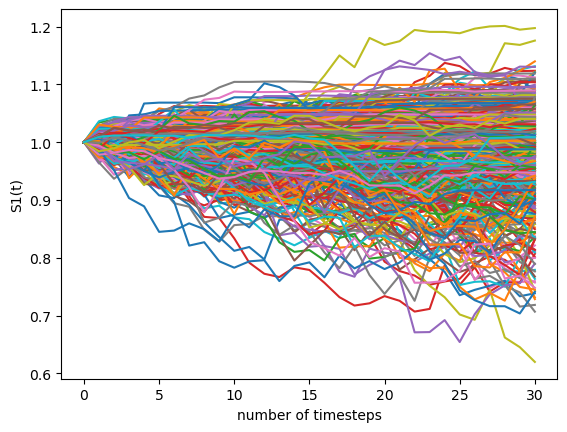

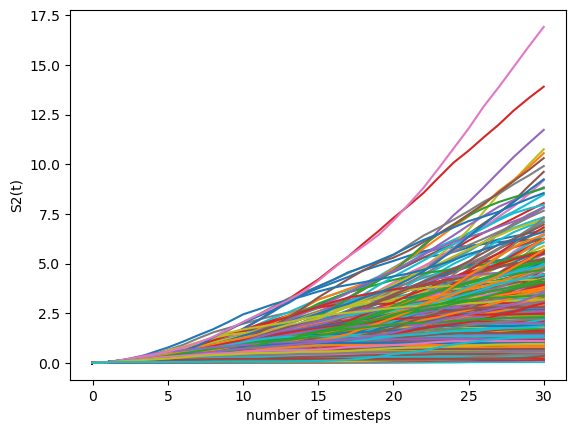

In [99]:
plt.figure()
plt.plot(paths_GBM)
plt.xlabel('number of timesteps')
plt.ylabel('S(t)')


plt.figure()
plt.plot(paths_Heston[:,:,0])
plt.xlabel('number of timesteps')
plt.ylabel('S1(t)')


plt.figure()
plt.plot(paths_Heston[:,:,1])
plt.xlabel('number of timesteps')
plt.ylabel('S2(t)')


# Exp: Parameter Uncertainty (Portfolio)

In [3]:
repo = analysis.Repo('./experiments1/')
key_list = list(repo.results.keys())
key_list2 = list(repo.results.keys())
print(key_list)

['24a8264f05249441b7cf29a07e803c8c3aed0c33']


# Exp3: Parameter Uncertainty

In [2]:
repo = analysis.Repo('./experiments/')
key_list = list(repo.results.keys())
key_list2 = list(repo.results.keys())
print(key_list)

['898da40d38eb70fe68caf81a53c7536fffd8d0e6', 'e3044667f0748ca0494d95e0367e5d355052a8a6', '32acb848e9f68897095a235fbcdacfe3984fb09e', 'dc45934872f603331ba85d4eb0634c89527982b9', '27ace46105f707c0b71d08a5a989e083d429915e', '29041787e9b0069ef241220906bded8a5b788ea0', '57d7b82efc2f2594137f305cc2a68644b0b7db44', 'a951d4590531d8af5dd1253d224efcefa59a5be7', '4fd450bdc08729f192174b58c1a92dc29ca61610', '779b6b8461c68950f122f492069969b0d4f73ffe', '1c3b94b0932caba359d3225d2155307aefa4d5b3', 'd1b73ab3c577f78175236e8a7148a5187b019071', 'febb7be5a925ca47a6800fdc86a93aa4d43c28a6', '77d39889976264be12882a1cfe67014606fb67da', 'da288495e281273f995df6b193599da4fc0ee23d', '1bdf59873be582801774e97102832a78fb4d2c96']


In [5]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    k =ref_keys
    sim_results[k] = repo.simulate_model(k, n_sims=100_000, days = 60, freq='D')
    paths = {k:{'ADS':sim_results[k]}}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k)}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec'])}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -2, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))

key_list = []
for k,v in repo.results.items():  
        key_list.append(k)
key_list.pop(1)

tmpT60={
        'ref_keys':key_list[4],
        'labels':{ 
                key_list[4]: 'weighted paths, T = 60'

                           
        }
}
experiments['deppT60'] = tmpT60

experiment = 'deppT60'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_resultsT60,hedge_modelsT60,specsT60, pathsT60,deltaT60,pnlT60  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
3125/3125 [==============================] - 5s 2ms/step


In [6]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    k =ref_keys
    sim_results[k] = repo.simulate_model(k, n_sims=100_000, days = 30, freq='12H')
    paths = {k:{'ADS':sim_results[k]}}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k)}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec'])}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -4, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))

key_list = []
for k,v in repo.results.items():  
        key_list.append(k)
key_list.pop(1)

tmpdt12={
        'ref_keys':key_list[10],
        'labels':{ 
                key_list[10]: 'weighted paths, dt = 12h'

                           
        }
}
experiments['deppdt12'] = tmpdt12

experiment = 'deppdt12'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_resultsdt12,hedge_modelsdt12,specsdt12, pathsdt12,deltadt12,pnldt12  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
3125/3125 [==============================] - 3s 1ms/step


In [7]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    k =ref_keys
    sim_results[k] = repo.simulate_model(k, n_sims=100_000, days = 30, parameter_uncertainty=True)
    paths = {k:{'ADS':sim_results[k]}}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k)}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec'])}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -2, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))

key_list = []
for k,v in repo.results.items():  
        key_list.append(k)
key_list.pop(1)

tmppuwrtvol={
        'ref_keys':key_list[12],
        'labels':{ 
                key_list[12]: 'weighted paths, paramunc wrt vol'

                           
        }
}
experiments['depppuwrtvol'] = tmppuwrtvol

experiment = 'depppuwrtvol'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_resultspuwrtvol,hedge_modelspuwrtvol,specspuwrtvol, pathspuwrtvol,deltapuwrtvol,pnlpuwrtvol  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
3125/3125 [==============================] - 3s 1ms/step


In [8]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    k =ref_keys
    sim_results[k] = repo.simulate_model(k, n_sims=100_000, days = 30, modelname = 'Heston')
    paths = {k:{'ADS':sim_results[k]}}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k)}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec'])}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -2, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        print(v[-1,:])
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))

key_list = []
for k,v in repo.results.items():  
        key_list.append(k)
key_list.pop(1)

tmpheston={
        'ref_keys':key_list[13],
        'labels':{ 
                key_list[13]: 'weighted paths, heston'

                           
        }
}
experiments['deppheston'] = tmpheston

experiment = 'deppheston'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_resultsheston,hedge_modelsheston,specsheston, pathsheston,deltaheston,pnlheston  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
[1.02246436 0.99278884 0.99123119 ... 1.00762    1.00269136 1.00728791]
3125/3125 [==============================] - 3s 958us/step


In [9]:
def setup(ref_keys):
    sim_results = {}
    paths = {}
    pnl = {}
    delta = {}
    indifference_price = {}
    # simulate paths
    print('simulate paths')
    k =ref_keys
    sim_results[k] = repo.simulate_model(k, n_sims=100_000, days = 30, modelname = 'Heston with Volswap')
    paths = {k:{'S1':sim_results[k][:,:,0] , 'S2':sim_results[k][:,:,1]}}
    # load models and specs
    print('load models and specs')
    hedge_models = {k: repo.get_hedge_model(k)}
    specs = {k: EuropeanVanillaSpecification.from_dict(repo.results[k]['spec'])}
    print('compute delta and pnl')
    for k,v in hedge_models.items():
        pnl[k] = compute_payoff(100_000, specs[k], paths[k], hedge_models[k])
        delta[k] = compute_delta(paths[k], -2, hedge_models[k])
        #indifference_price[k] = compute_indifference_price(100_000,paths[k],specs[k],hedge_models[k])
        
    return sim_results, hedge_models, specs, paths, delta,pnl

def compute_payoff(n_sims, specs, paths, hedge_model):
    pnl = {}
    delta = {}
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        print(v[-1,:])
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    pnl = hedge_model.compute_pnl(paths, payoff)
    return pnl

def compute_delta(paths, t, hedge_model):
    delta = hedge_model.compute_delta(paths, t).reshape((-1,))
    return delta 


def compute_indifference_price(n_sims, paths,specs,hedge_model):
    payoff = np.zeros((n_sims,))
    for k in paths.keys(): 
        v = paths[k]
        payoff -= np.maximum(v[-1,:] - specs.strike,0)
    indifference_price = hedge_model.compute_indifference_price(paths,payoff)
    return indifference_price


#def compute_indifference_price(self,paths: Dict[str, np.ndarray],                   
#                    payoff: np.ndarray):
#        inputs = self._create_inputs(paths)
#        a = np.exp(-self.regularization*(payoff + self.predict(inputs)))
#        b = np.exp(-self.regularization*(self.predict(inputs)))
#        c = 1./self.regularization
#        return c*np.log(np.mean(a)/np.mean(b))

key_list = []
for k,v in repo.results.items():  
        key_list.append(k)
key_list.pop(1)

tmphestonwvs={
        'ref_keys':key_list[14],
        'labels':{ 
                key_list[14]: 'weighted paths, heston with volswap'

                           
        }
}
experiments['depphestonwvs'] = tmphestonwvs

experiment = 'depphestonwvs'
ref_keys = experiments[experiment]['ref_keys']
labels = experiments[experiment]['labels']
labels_T = {k:v for v,k in labels.items()}
sim_resultshestonwvs,hedge_modelshestonwvs,specshestonwvs, pathshestonwvs,deltahestonwvs,pnlhestonwvs  = setup(ref_keys)

simulate paths
load models and specs
compute delta and pnl
[1.02246436 0.99278884 0.99123119 ... 1.00762    1.00269136 1.00728791]
[0.12825285 0.52580062 2.75891722 ... 0.2917605  0.39231476 0.43329336]
3125/3125 [==============================] - 3s 978us/step


In [10]:
df = pd.DataFrame.from_dict(delta)
df =df.rename(columns=tmp['labels'])
df.insert(0, "v", sim_results[key_list[0]][-2,:], True)
model = GBM(drift = 0., volatility=0.2)
timegrid = VanillaOptionDeepHedgingPricer._compute_timegrid(days=30, freq ='D')
delta_BS = model.compute_BS_delta(df['v'],timegrid)
df.insert(1, "Black Scholes", delta_BS, True)
df

v  Black Scholes  \
0      0.943049   1.879909e-08   
1      0.950532   9.704455e-07   
2      0.997011   3.913553e-01   
3      0.984010   6.570742e-02   
4      0.965472   4.924723e-04   
...         ...            ...   
99995  1.030205   9.974460e-01   
99996  1.045006   9.999826e-01   
99997  1.139613   1.000000e+00   
99998  0.962851   1.924818e-04   
99999  0.998145   4.328704e-01   

       Benchmark Long Call, vol = 0.2, T = 30days, dt = 1day  weighted paths  \
0                                               0.003137           -0.006526   
1                                               0.008718           -0.008771   
2                                               0.491942            0.504430   
3                                               0.216242            0.211432   
4                                               0.037428            0.035343   
...                                                  ...                 ...   
99995                                           0.974330            0.978466   
99996                                           1.017784            1.021373   
99997                                           1.016106            1.005294   
99998                                           0.027893            0.022663   
99999                                           0.523333            0.532649   

       weighted paths, vol = 0.1  weighted paths, vol = 0.3  \
0                      -0.009490                   0.011613   
1                      -0.013162                   0.031816   
2                       0.428387                   0.512679   
3                       0.040483                   0.285693   
4                      -0.016605                   0.088928   
...                          ...                        ...   
99995                   1.020393                   0.885437   
99996                   1.016739                   0.967478   
99997                   1.027018                   1.015102   
99998                  -0.016972                   0.076682   
99999                   0.482537                   0.527933   

       weighted paths, tc = 1.e-10  weighted paths, tc = 0.0001  \
0                        -0.002213                     0.007210   
1                         0.002120                    -0.002461   
2                         0.486273                     0.494255   
3                         0.227074                     0.233222   
4                         0.039005                     0.035338   
...                            ...                          ...   
99995                     0.973469                     0.968720   
99996                     1.009666                     1.011764   
99997                     1.002738                     1.014784   
99998                     0.027235                     0.023005   
99999                     0.517789                     0.523972   

       weighted paths, tc = 0.001  weighted paths, tc = 0.01  \
0                       -0.000629                  -0.013423   
1                        0.006986                  -0.011543   
2                        0.537163                   0.599139   
3                        0.236477                   0.287191   
4                        0.035144                   0.038527   
...                           ...                        ...   
99995                    0.976845                   0.995814   
99996                    1.026106                   1.023706   
99997                    1.007974                   1.020927   
99998                    0.029655                   0.023653   
99999                    0.562828                   0.625198   

       Benchmark Put - TODO  Short Call  
0                 -0.011343    0.011346  
1                 -0.000502    0.002545  
2                  0.507632   -0.502547  
3                  0.228554   -0.201594  
4                  0.035295   -0.043460  
...                     ...         ...  
99995              

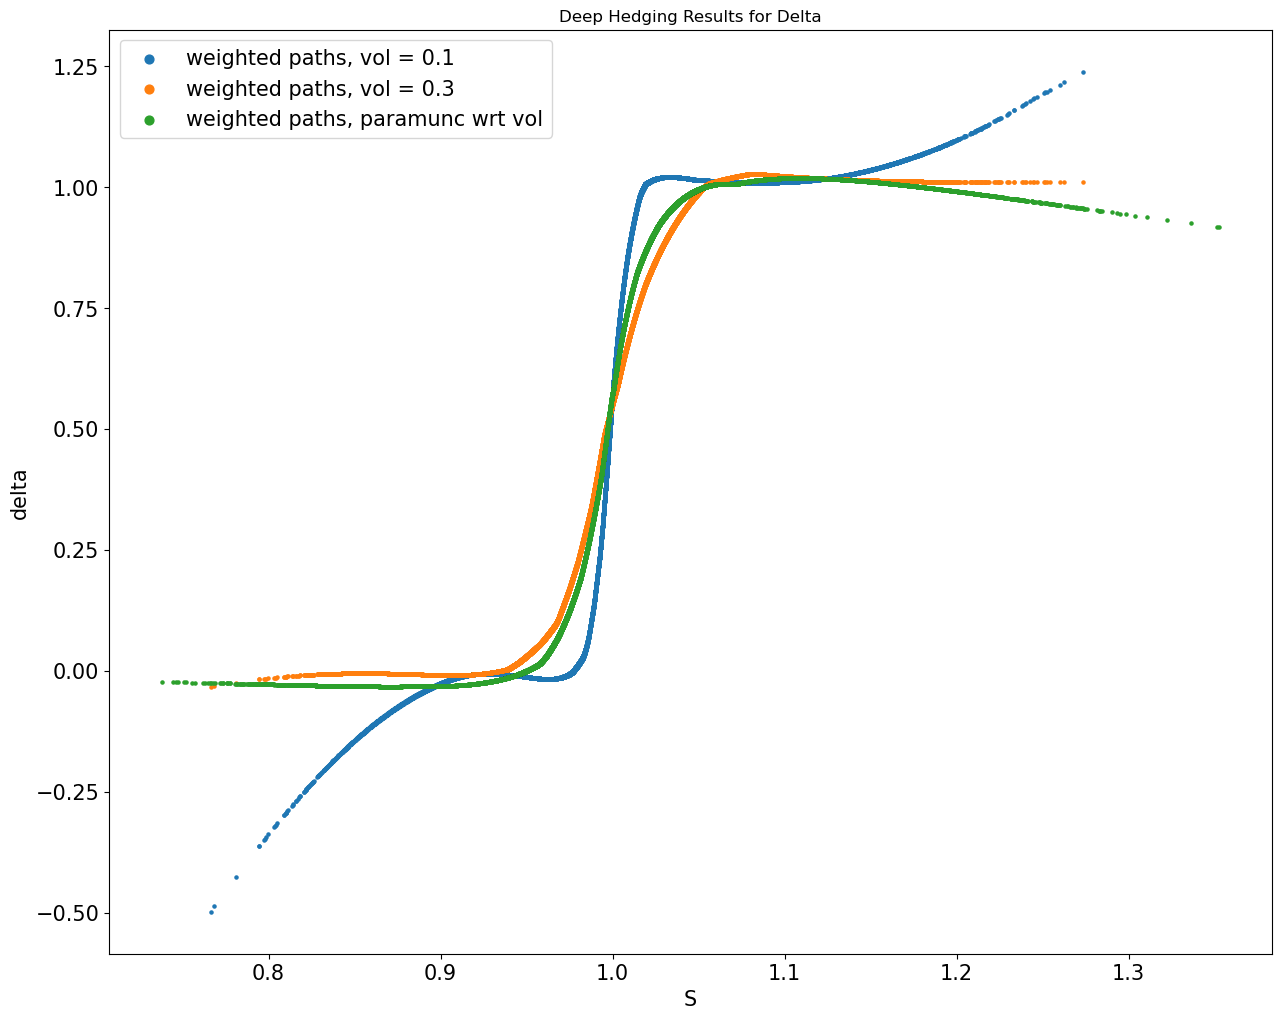

In [13]:
size = 15
plt.figure(figsize=(15,12))
for i in range(4,7):
    if i-2 == 4:
        continue
    plt.scatter(x = sim_results[key_list[i-2]][-2,:], y = df[df.columns[i]], label = df.columns[i], s = 5)
#plt.scatter(x = df['v'], y = df['Black Scholes'], label ='Black Scholes', color = 'black',s =5)
#plt.scatter(x = sim_resultsT60[key_list[4]][-2,:], y = deltaT60[key_list[4]], label = 'weighted paths, T = 60', s = 5)
#plt.scatter(x = sim_resultsdt12[key_list[10]][-4,:], y = deltadt12[key_list[10]], label = 'weighted paths, dt = 12h', s = 5)
plt.scatter(x = sim_resultspuwrtvol[key_list[12]][-2,:], y = deltapuwrtvol[key_list[12]], label = 'weighted paths, paramunc wrt vol', s = 5)
#plt.scatter(x = sim_resultshestonwvs[key_list[14]][-2,:], y = deltahestonwvs[key_list[14]], label = 'Heston with Volswap', s = 5)
lgnd = plt.legend(fontsize=size)
for handle in lgnd.legend_handles:
    handle.set_sizes([40.0])
plt.xlabel('S',size = size)
plt.ylabel('delta',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.title('Deep Hedging Results for Delta')
#plt.xlim([0.95,1.05])
plt.show()

c:\Users\Anwender\.conda\envs\rivapyFS\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



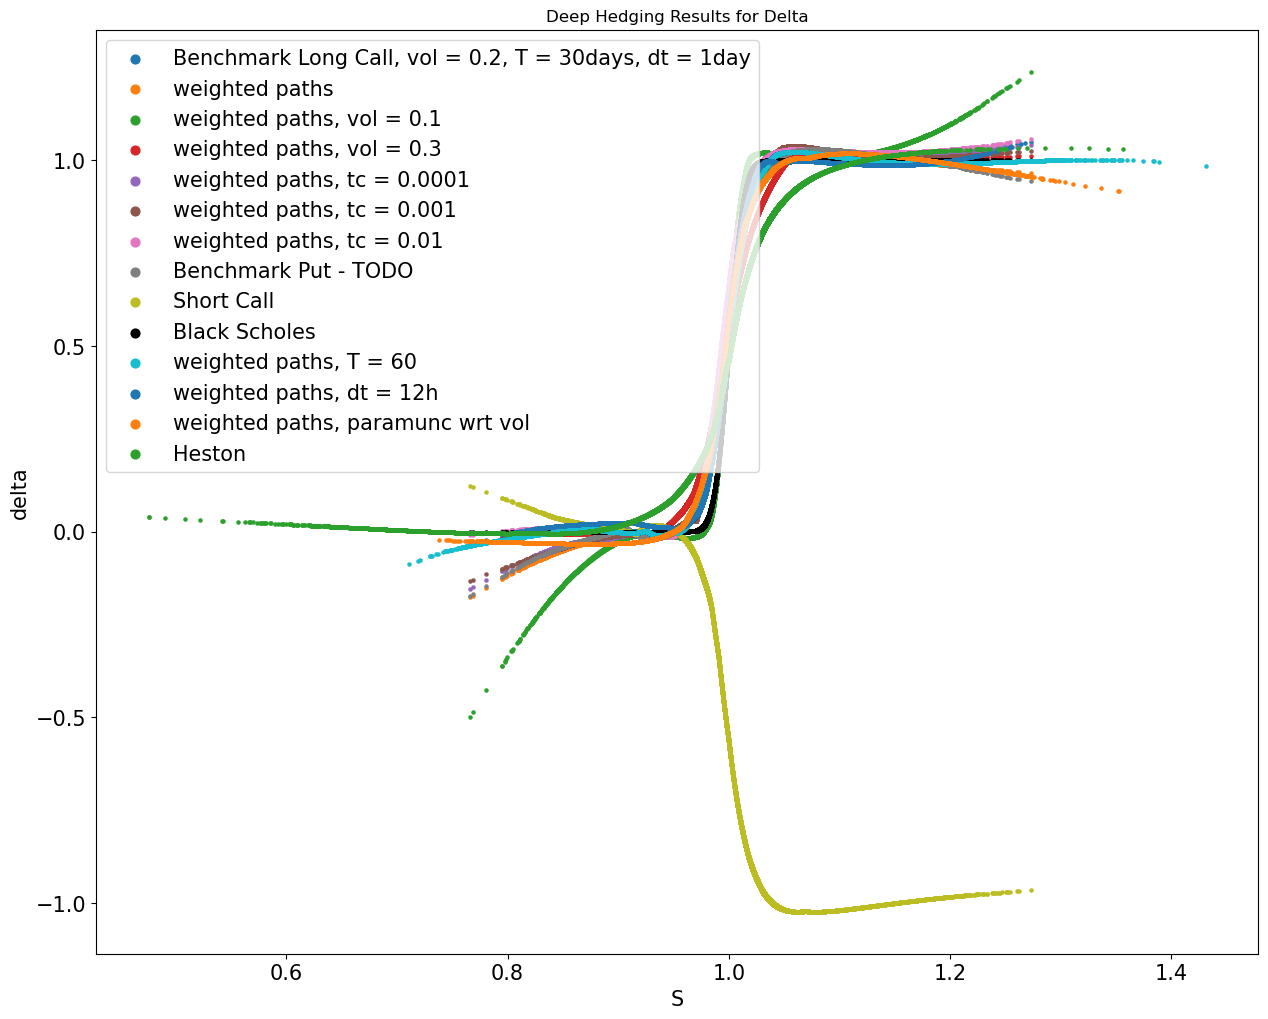

In [11]:
size = 15
plt.figure(figsize=(15,12))
for i in range(2,len(df.columns)):
    if i-2 == 4:
        continue
    plt.scatter(x = sim_results[key_list[i-2]][-2,:], y = df[df.columns[i]], label = df.columns[i], s = 5)
#plt.scatter(x = df['v'], y = df['Black Scholes'], label ='Black Scholes', color = 'black',s =5)
#plt.scatter(x = sim_resultsT60[key_list[4]][-2,:], y = deltaT60[key_list[4]], label = 'weighted paths, T = 60', s = 5)
#plt.scatter(x = sim_resultsdt12[key_list[10]][-4,:], y = deltadt12[key_list[10]], label = 'weighted paths, dt = 12h', s = 5)
plt.scatter(x = sim_resultspuwrtvol[key_list[12]][-2,:], y = deltapuwrtvol[key_list[12]], label = 'weighted paths, paramunc wrt vol', s = 5)
#plt.scatter(x = sim_resultsheston[key_list[13]][-2,:], y = deltaheston[key_list[13]], label = 'Heston', s = 5)
#plt.scatter(x = sim_resultshestonwvs[key_list[14]][-2,:], y = deltahestonwvs[key_list[14]], label = 'Heston with Volswap', s = 5)
lgnd = plt.legend(fontsize=size)
for handle in lgnd.legend_handles:
    handle.set_sizes([40.0])
plt.xlabel('S',size = size)
plt.ylabel('delta',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
plt.title('Deep Hedging Results for Delta')
#plt.xlim([0.95,1.05])
plt.show()

In [57]:
df_pnl = pd.DataFrame.from_dict(pnl)
df_pnl =df_pnl.rename(columns=tmp['labels'])

In [58]:
df_pnl

Benchmark Long Call, vol = 0.2, T = 30days, dt = 1day  weighted paths  \
0                                              -0.023868           -0.024001   
1                                              -0.024498           -0.024817   
2                                              -0.016302           -0.016780   
3                                              -0.016792           -0.016895   
4                                              -0.024820           -0.024993   
...                                                  ...                 ...   
99995                                          -0.021963           -0.022168   
99996                                          -0.024398           -0.024498   
99997                                          -0.023139           -0.022869   
99998                                          -0.023773           -0.023926   
99999                                          -0.011307           -0.011382   

       weighted paths, vol = 0.1  weighted paths, vol = 0.3  \
0                      -0.020215                  -0.024816   
1                      -0.020745                  -0.025648   
2                      -0.027245                  -0.011982   
3                      -0.015823                  -0.014042   
4                      -0.029485                  -0.022743   
...                          ...                        ...   
99995                  -0.034050                  -0.017279   
99996                  -0.026309                  -0.024047   
99997                  -0.014779                  -0.028655   
99998                  -0.026158                  -0.021306   
99999                  -0.018618                  -0.008167   

       weighted paths, tc = 1.e-10  weighted paths, tc = 0.0001  \
0                        -0.023834                    -0.024186   
1                        -0.024201                    -0.024801   
2                        -0.016303                    -0.016545   
3                        -0.016813                    -0.016762   
4                        -0.024935                    -0.025090   
...                            ...                          ...   
99995                    -0.022013                    -0.021991   
99996                    -0.024183                    -0.024577   
99997                    -0.023977                    -0.022879   
99998                    -0.023615                    -0.024216   
99999                    -0.011261                    -0.011377   

       weighted paths, tc = 0.001  weighted paths, tc = 0.01  \
0                       -0.025777                  -0.036361   
1                       -0.026240                  -0.036255   
2                       -0.018114                  -0.029879   
3                       -0.017813                  -0.027331   
4                       -0.026780                  -0.037932   
...                           ...                        ...   
99995                   -0.023714                  -0.036620   
99996                   -0.026119                  -0.038183   
99997                   -0.024994                  -0.033480   
99998                   -0.025524                  -0.037424   
99999                   -0.012480                  -0.021893   

       Benchmark Put - TODO  Short Call  
0                 -0.024307    0.023968  
1                 -0.024476    0.024482  
2                 -0.016634    0.011833  
3                 -0.016690    0.016843  
4                 -0.025110    0.025032  
...                     ...         ...  
99995             -0.021985   -0.007614  
99996             -0.024257   -0.037974  
99997             -0.022398   -0.292578  
99998             -0.023951    0.023958  
99999             -0.011275    0.011177  

[100000 rows x 10 columns]

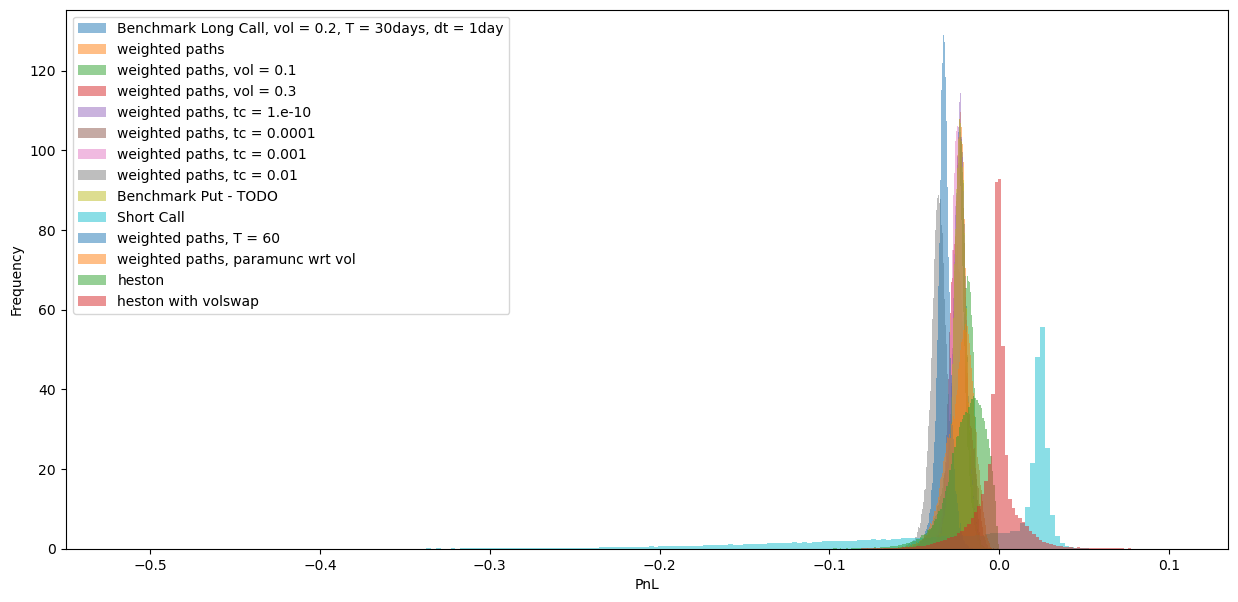

In [60]:
size = 10
plt.figure(figsize=(15,7))
for i in range(len(df_pnl.columns)):
    plt.hist(df_pnl[df_pnl.columns[i]], bins=200, label=df_pnl.columns[i], density=True, alpha=0.5)
plt.hist(pnlT60['29041787e9b0069ef241220906bded8a5b788ea0'], bins=200, label='weighted paths, T = 60',density=True, alpha=0.5)
plt.hist(pnlpuwrtvol[key_list[12]], bins=200, label='weighted paths, paramunc wrt vol',density=True, alpha=0.5)
plt.hist(pnlheston[key_list[13]], bins=200, label='heston',density=True, alpha=0.5)
plt.hist(pnlhestonwvs[key_list[14]], bins=200, label='heston with volswap',density=True, alpha=0.5)
plt.legend(fontsize=size)
plt.xlabel('PnL',size = size)
plt.ylabel('Frequency',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xlim([0.95,1.05])
plt.show()

In [70]:
repo.results[key_list[1]]['pnl_result']


{'mean': -0.023252089995929478,
 'var': 1.973920739955432e-05,
 'loss': 1.9106648323941045e-05,
 '1%': -0.03666830837726593,
 '99%': -0.013170627704920251,
 '5%': -0.030457703702154035,
 '95%': -0.016453266832854186}

In [71]:
repo.results[key_list[2]]['pnl_result']

{'mean': -0.011626634751029707,
 'var': 4.761539443968581e-06,
 'loss': 4.60902128907037e-06,
 '1%': -0.01826692134141922,
 '99%': -0.006620526010472866,
 '5%': -0.01514720302460958,
 '95%': -0.008290171014722321}

In [72]:
repo.results[key_list[3]]['pnl_result']

{'mean': -0.034875759267902845,
 'var': 4.182871003059448e-05,
 'loss': 4.048480332130566e-05,
 '1%': -0.05488153517246246,
 '99%': -0.019828993970039777,
 '5%': -0.04542386565525199,
 '95%': -0.02491550389299302}

In [65]:
repo.results[key_list[12]]['pnl_result']

{'mean': -0.02190215129439833,
 'var': 7.904042538382012e-05,
 'loss': 2.3574109945911914e-05,
 '1%': -0.04639235450983812,
 '99%': -0.0055449885673894,
 '5%': -0.03661430682986975,
 '95%': -0.008615545928478243}

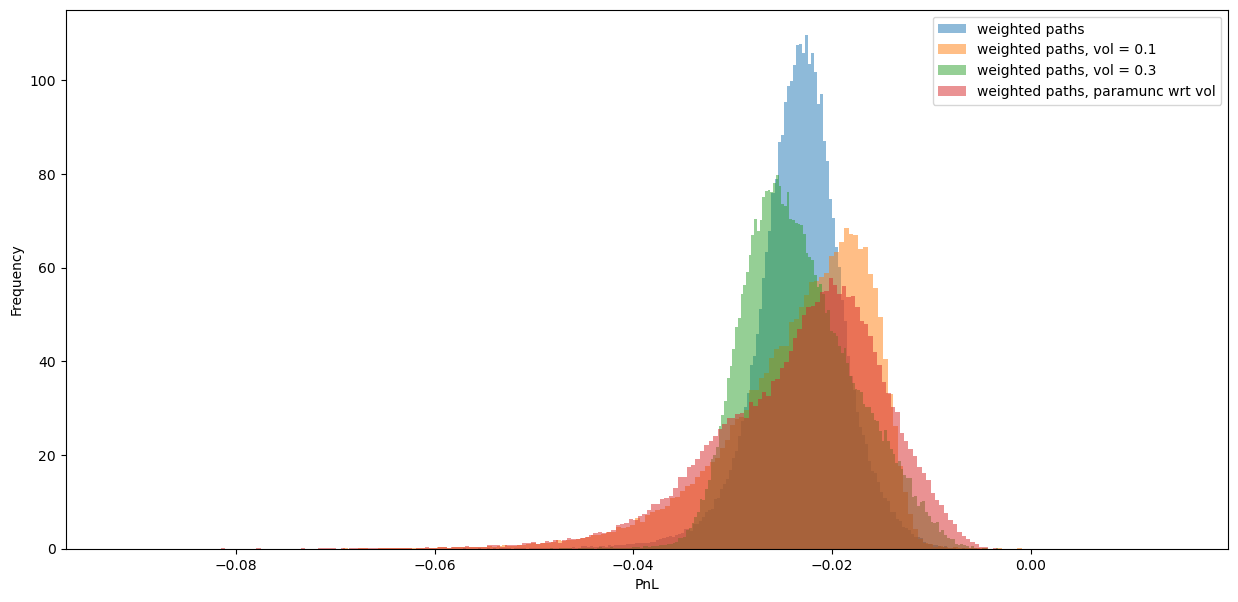

In [69]:
size = 10
plt.figure(figsize=(15,7))
plt.hist(df_pnl[df_pnl.columns[1]], bins=200, label=df_pnl.columns[1], density=True, alpha=0.5)
plt.hist(df_pnl[df_pnl.columns[2]], bins=200, label=df_pnl.columns[2], density=True, alpha=0.5)
plt.hist(df_pnl[df_pnl.columns[3]], bins=200, label=df_pnl.columns[3], density=True, alpha=0.5)
plt.hist(pnlpuwrtvol[key_list[12]], bins=200, label='weighted paths, paramunc wrt vol',density=True, alpha=0.5)
plt.legend(fontsize=size)
plt.xlabel('PnL',size = size)
plt.ylabel('Frequency',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xlim([0.95,1.05])
plt.show()

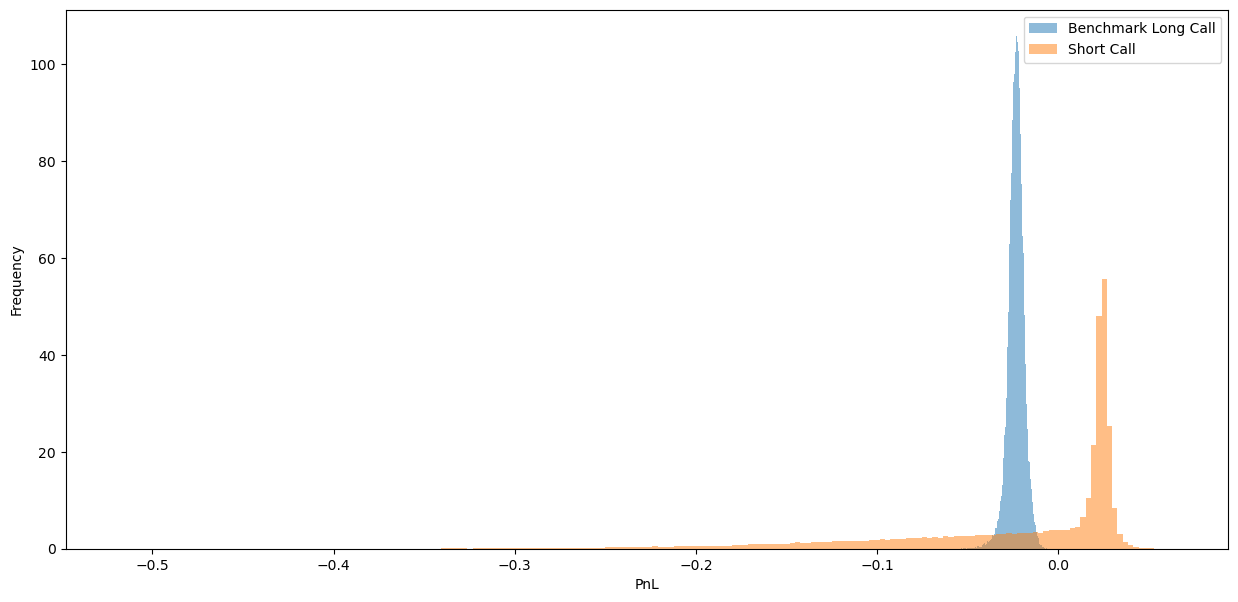

In [62]:
size = 10
plt.figure(figsize=(15,7))
plt.hist(df_pnl['Benchmark Long Call, vol = 0.2, T = 30days, dt = 1day'], bins=200, label='Benchmark Long Call', density=True, alpha=0.5)
plt.hist(df_pnl['Short Call'], bins=200, label='Short Call',density=True, alpha=0.5)
plt.legend(fontsize=size)
plt.xlabel('PnL',size = size)
plt.ylabel('Frequency',size = size)
plt.xticks(size=size)
plt.yticks(size=size)
#plt.xlim([0.95,1.05])
plt.show()